# Scratch pad for FF foundation/academia

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils.calcs import odds_ratio

from utils.io import yaml_to_dict

from statsmodels.stats.proportion import proportions_ztest

# Living on the edge w/o warning text
import warnings

warnings.filterwarnings("ignore")

# automagically make the code pretty
%load_ext jupyter_black

## Read data, describe

In [8]:
ff_df = pd.read_csv(
    "/Users/lindseygulden/dev/leg-up-private/projects/foundation/data/grant_recipient_linked.csv",
    dtype={"ein": str, "unitid": str, "year": int},
)


ff_df["tier1_research"] = [1 if (x == 1) else 0 for x in ff_df.research2025]

#
n_schools = ff_df.carnegie_matched.nunique()
n_grants = len(ff_df)
total_nominal = ff_df.grant_amount.sum()
total_2024 = ff_df.grant_amount_2024_usd.sum()


print(
    f" Analysis dataset contains {n_grants:.0f} grants made to {n_schools:.0f} institutions of higher education"
)
print(
    f" Total contributions to universities between 2003 and 2024 were ${total_nominal:,.0f} [nominal USD]"
)
print(
    f" Total contributions to universities between 2003 and 2024 were ${total_2024:,.0f} [2024 USD]"
)
print("Fraction of grants that were from corporate foundations vs. family foundations:")
print(ff_df[["family", "grant_amount_2024_usd"]].groupby("family").sum() / total_2024)

 Analysis dataset contains 7514 grants made to 981 institutions of higher education
 Total contributions to universities between 2003 and 2024 were $1,666,481,019 [nominal USD]
 Total contributions to universities between 2003 and 2024 were $2,181,173,113 [2024 USD]
Fraction of grants that were from corporate foundations vs. family foundations:
        grant_amount_2024_usd
family                       
0                    0.522284
1                    0.477716


In [9]:
ff_df.sort_values(by="grant_amount_2024_usd", ascending=False, inplace=True)
ff_df[
    [
        "foundation_name",
        "year",
        "grant_amount",
        "grant_amount_2024_usd",
        "carnegie_matched",
    ]
].head(50)

,foundation_name,year,grant_amount,grant_amount_2024_usd,carnegie_matched
7261,Anschutz Foundation,2007,27260264.0,4.124222e+07,University of Colorado Boulder
7151,Anschutz Foundation,2019,27000000.0,3.312877e+07,University of Colorado Denver/Anschutz Medical...
4616,Charles Koch Foundation,2019,17608073.0,2.160496e+07,George Mason University
7270,Anschutz Foundation,2006,13641736.0,2.122650e+07,University of Colorado Denver/Anschutz Medical...
4511,Charles Koch Foundation,2020,16551945.0,2.006160e+07,George Mason University
7140,Anschutz Foundation,2021,17000000.0,1.968009e+07,University of Colorado Denver/Anschutz Medical...
4766,Charles Koch Foundation,2018,15687900.0,1.959771e+07,George Mason University
5241,Charles Koch Foundation,2015,13269401.0,1.756188e+07,George Mason University
5107,Charles Koch Foundation,2016,13399270.0,1.751284e+07,George Mason University
4932,Charles Koch Foundation,2017,13468800.0,1.723651e+07,George Mason University


In [10]:
unique_u_df = ff_df.groupby("carnegie_matched").first()
unique_u_df[["grant_amount_2024_usd", "research2025name"]].groupby(
    "research2025name"
).agg(["count", "sum"])

grant_amount_2024_usd  \
                                                                   count   
research2025name                                                           
No research designation                                              590   
Research 1: Very High Spending and Doctorate Pr...                   172   
Research 2: High Spending and Doctorate Production                    99   
Research Colleges and Universities                                   101   

                                                                  
                                                             sum  
research2025name                                                  
No research designation                             1.223464e+08  
Research 1: Very High Spending and Doctorate Pr...  2.902896e+08  
Research 2: High Spending and Doctorate Production  5.564827e+07  
Research Colleges and Universities                  4.857966e+07

## Distributions of distance b/w grantmaker and recipient

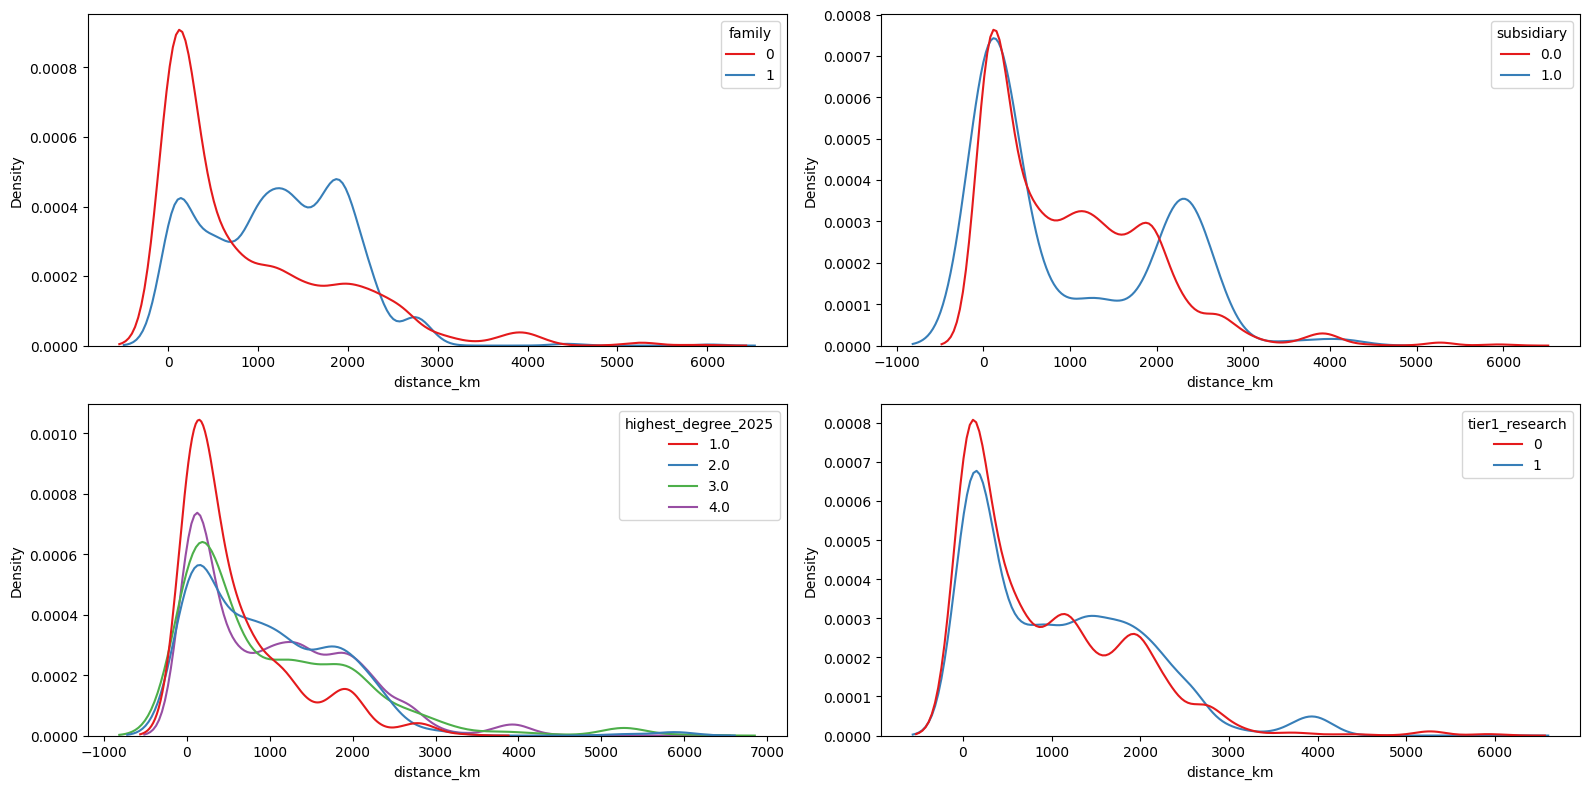

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
for i, huevar in enumerate(
    ["family", "subsidiary", "highest_degree_2025", "tier1_research"]
):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(
        data=ff_df,
        x="distance_km",
        hue=huevar,
        palette="Set1",
        common_norm=False,
    )

fig.tight_layout()

## Read Will data

In [14]:
will_df = pd.read_csv("projects/foundation/will/outputs/final_datasets/df_ff.csv")
# will_grantmakers = list(will_df.loc[will_df.FF_INTEREST == "X"].GRANTMAKER.unique())
# pd.Series(sorted(will_grantmakers)).to_clipboard()

# adjust will's data for inflation with his code
will_df.columns = [x.lower().replace(" ", "_") for x in will_df.columns.values]
cpi_data = {
    2003: 184,
    2004: 188.9,
    2005: 195.3,
    2006: 201.6,
    2007: 207.3,
    2008: 215.3,
    2009: 214.5,
    2010: 218.1,
    2011: 224.9,
    2012: 229.6,
    2013: 233,
    2014: 236.7,
    2015: 237,
    2016: 240,
    2017: 245.1,
    2018: 251.1,
    2019: 255.7,
    2020: 258.8,
    2021: 271,
    2022: 292.7,
    2023: 304.7,
}

# CPI on January 1st, 2023 (replace with actual value)
cpi_2023 = 304.7


def adjust_for_inflation(row):
    year = row["year_authorized"]
    grant_amount = row["grant_amount"]

    # Get the CPI for the year the grant was authorized
    cpi_year = cpi_data.get(year, None)

    if cpi_year is None:
        return None  # Or handle missing CPI data as needed

    # Calculate the inflation adjustment factor
    inflation_factor = cpi_2023 / cpi_year

    # Calculate the adjusted grant amount
    return grant_amount * inflation_factor


will_df["grant_amount_2023_usd"] = will_df.apply(adjust_for_inflation, axis=1)

### Total Fossil-fuel foundation grant spending through time

#### Figure comparing two data-gathering methods

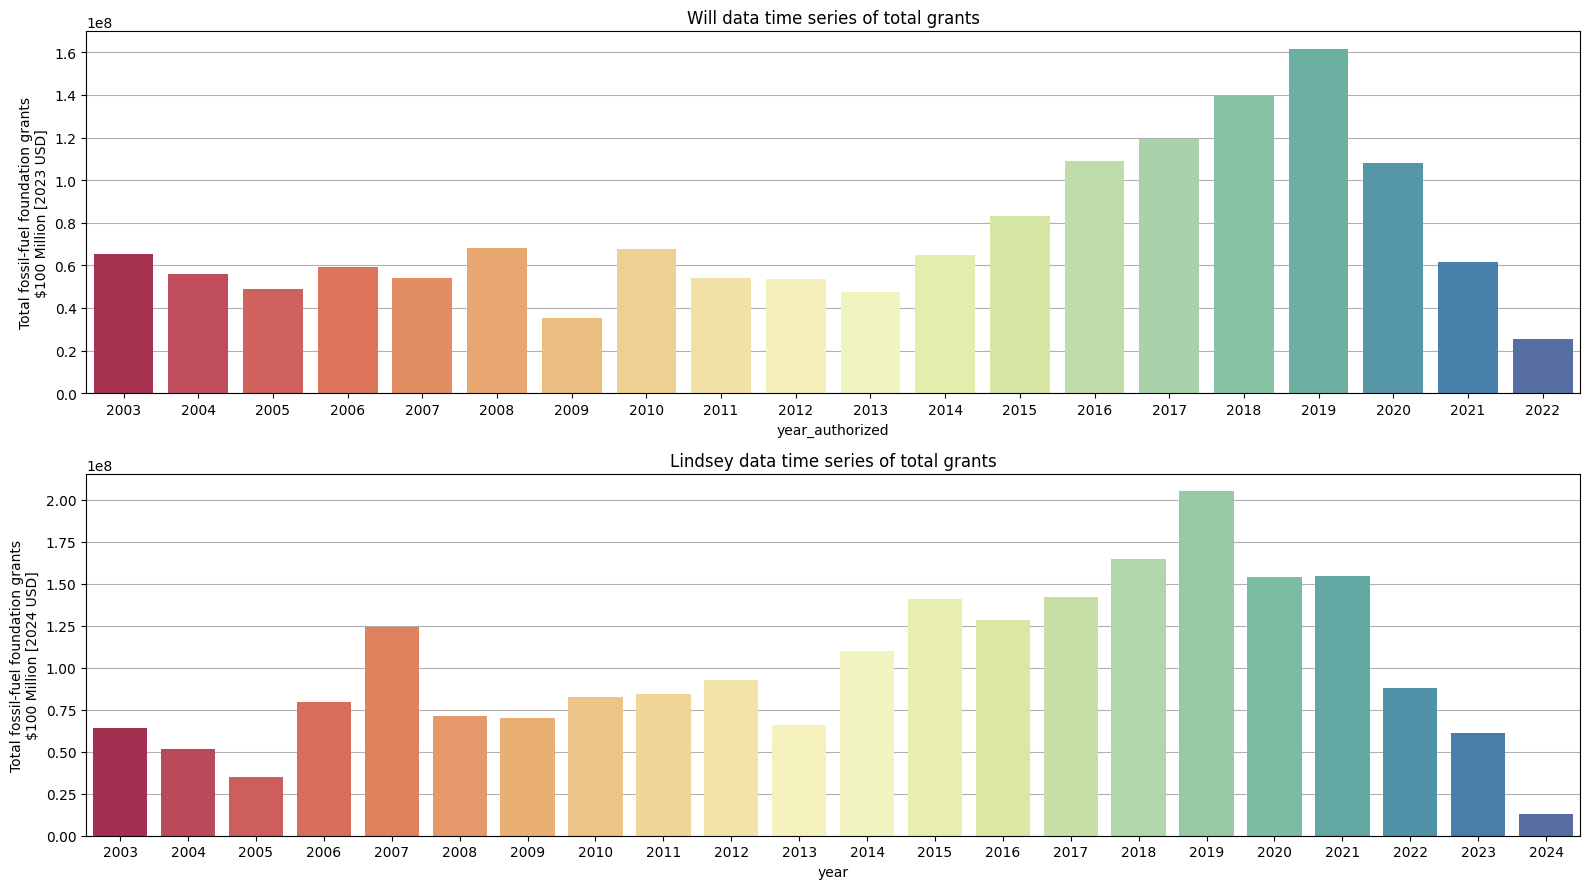

In [15]:
data_df = (
    will_df[["grant_amount_2023_usd", "year_authorized"]]
    .groupby("year_authorized")
    .sum()
    .reset_index()
)
fig, axes = plt.subplots(2, 1, figsize=(16, 9))
# plot will data, through time
ax = axes[0]
ax.grid(axis="y")
sns.barplot(
    ax=ax,
    data=data_df,
    x="year_authorized",
    y="grant_amount_2023_usd",
    palette="Spectral",
)
ax.set_axisbelow(True)  # put gridlines below bars
ax.set_ylabel("Total fossil-fuel foundation grants\n$100 Million [2023 USD]")
ax.set_title("Will data time series of total grants")

# plot lindsey data, through time
ax = axes[1]
data_df = ff_df[["grant_amount_2024_usd", "year"]].groupby("year").sum().reset_index()
ax.grid(axis="y")
sns.barplot(
    ax=ax, data=data_df, x="year", y="grant_amount_2024_usd", palette="Spectral"
)
ax.set_axisbelow(True)  # put gridlines below bars
ax.set_ylabel("Total fossil-fuel foundation grants\n$100 Million [2024 USD]")
ax.set_title("Lindsey data time series of total grants")

plt.tight_layout()

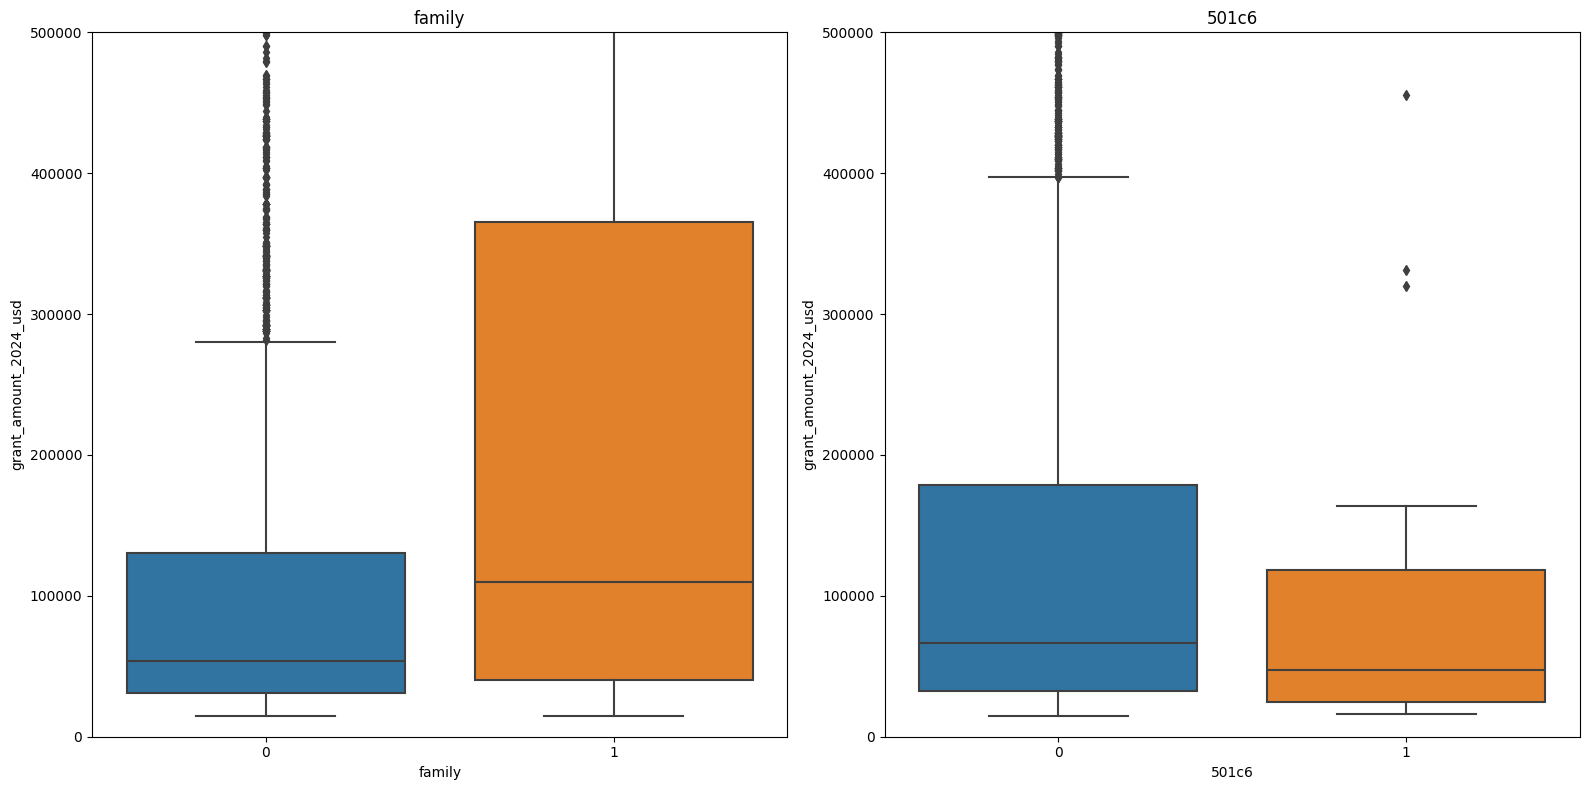

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for i, var in enumerate(["family", "501c6"]):
    sns.boxplot(
        ax=ax[i],
        data=ff_df[["grant_amount_2024_usd", var]],
        y="grant_amount_2024_usd",
        x=var,
    )
    ax[i].set_title(var)
    ax[i].set_ylim([0, 0.5e6])
plt.tight_layout()

In [17]:
# name of carnegie variable: [value when 'yes', value when 'no]
data_dict = {
    "landgrant": [1, 2],
    "medical": [1, 0],
    "hbcu": [1, 0],
    "rpu": [1, 0],
    "womenonly": [1, 0],
    "tribal": [1, 0],
    "hsi": [1, 0],
    "pbi": [1, 0],
}


carnegie_all_df = pd.read_csv(
    "/Users/lindseygulden/dev/leg-up-private/projects/foundation/data/carnegie_data_2025.csv"
)
student_enrollment_col = "size_avg"
total_students = carnegie_all_df[student_enrollment_col].sum()

total_grants = ff_df.grant_amount_2024_usd.sum()


for var, yn in data_dict.items():
    print(var)
    g_df = ff_df[[var, "grant_amount_2024_usd"]].groupby(var).sum() / total_grants
    # print(g_df)
    s_df = (
        carnegie_all_df[[student_enrollment_col, var]].groupby(var).sum()
        / total_students
    )
    # print(s_df)
    var_df = g_df.merge(s_df, right_index=True, left_index=True)
    var_df.index = ["yes" if x == yn[0] else "no" for x in var_df.index]
    print(var_df)
    print("")

landgrant
     grant_amount_2024_usd  size_avg
yes               0.179084  0.085869
no                0.803959  0.914131

medical
     grant_amount_2024_usd  size_avg
no                0.564080  0.824376
yes               0.418964  0.175624

hbcu
     grant_amount_2024_usd  size_avg
no                0.957466  0.986167
yes               0.025577  0.013833

rpu
     grant_amount_2024_usd  size_avg
no                0.872057  0.791357
yes               0.110987  0.208643

womenonly
     grant_amount_2024_usd  size_avg
no                0.973236  0.997512
yes               0.009808  0.002488

tribal
     grant_amount_2024_usd  size_avg
no                0.982683  0.999038
yes               0.000360  0.000962

hsi
     grant_amount_2024_usd  size_avg
no                0.843782  0.718348
yes               0.139262  0.281652

pbi
     grant_amount_2024_usd  size_avg
no                0.979144  0.982819
yes               0.003900  0.017181



### Universities with most fossil-fuel foundation funding

In [18]:
ff_df[["grant_amount", "grant_amount_2024_usd", "carnegie_matched"]].groupby(
    "carnegie_matched"
).sum().sort_values(by="grant_amount_2024_usd", ascending=False).head(50)

,grant_amount,grant_amount_2024_usd
carnegie_matched,,
George Mason University,154934886.0,1.994826e+08
University of Colorado Denver/Anschutz Medical Campus,104429541.0,1.329539e+08
University of Nebraska-Lincoln,53532486.0,6.813063e+07
Harvard University,46734752.0,6.197410e+07
Georgia Institute of Technology-Main Campus,45119314.0,5.571728e+07
Icahn School of Medicine at Mount Sinai,40975000.0,5.435735e+07
University of Colorado Boulder,32722842.0,4.854550e+07
Arizona State University Campus Immersion,35152139.0,4.313543e+07
Bradley University,26586245.0,3.876368e+07


### Top spenders (grantmakers/foundations)

[Text(0, 0, 'Charles Koch Foundation'),
 Text(1, 0, 'Anschutz Foundation'),
 Text(2, 0, 'The Robert D And Patricia E Kern Family Foundation Inc'),
 Text(3, 0, 'Hess Foundation Inc'),
 Text(4, 0, 'Caterpillar Foundation'),
 Text(5, 0, 'Peter Kiewit Foundation'),
 Text(6, 0, 'The Duke Energy Foundation'),
 Text(7, 0, 'Dow Company Foundation'),
 Text(8, 0, 'Herbert H & Grace A Dow Foundation'),
 Text(9, 0, 'Southern Company Charitable Foundation Inc'),
 Text(10, 0, 'Bp Foundation Inc'),
 Text(11, 0, 'Alabama Power Foundation Inc'),
 Text(12, 0, 'Blackstone Charitable Foundation'),
 Text(13, 0, 'American Electric Power Foundation'),
 Text(14, 0, 'Delta Air Lines Foundation'),
 Text(15, 0, 'Exxonmobil Foundation'),
 Text(16, 0, 'Shell Usa Company Foundation'),
 Text(17, 0, 'Valero Energy Foundation'),
 Text(18, 0, 'Dte Energy Foundation'),
 Text(19, 0, 'Lockheed Martin Corporation Fndn'),
 Text(20, 0, 'Union Pacific Foundation'),
 Text(21, 0, 'Georgia Power Foundation Inc In Receivership'),

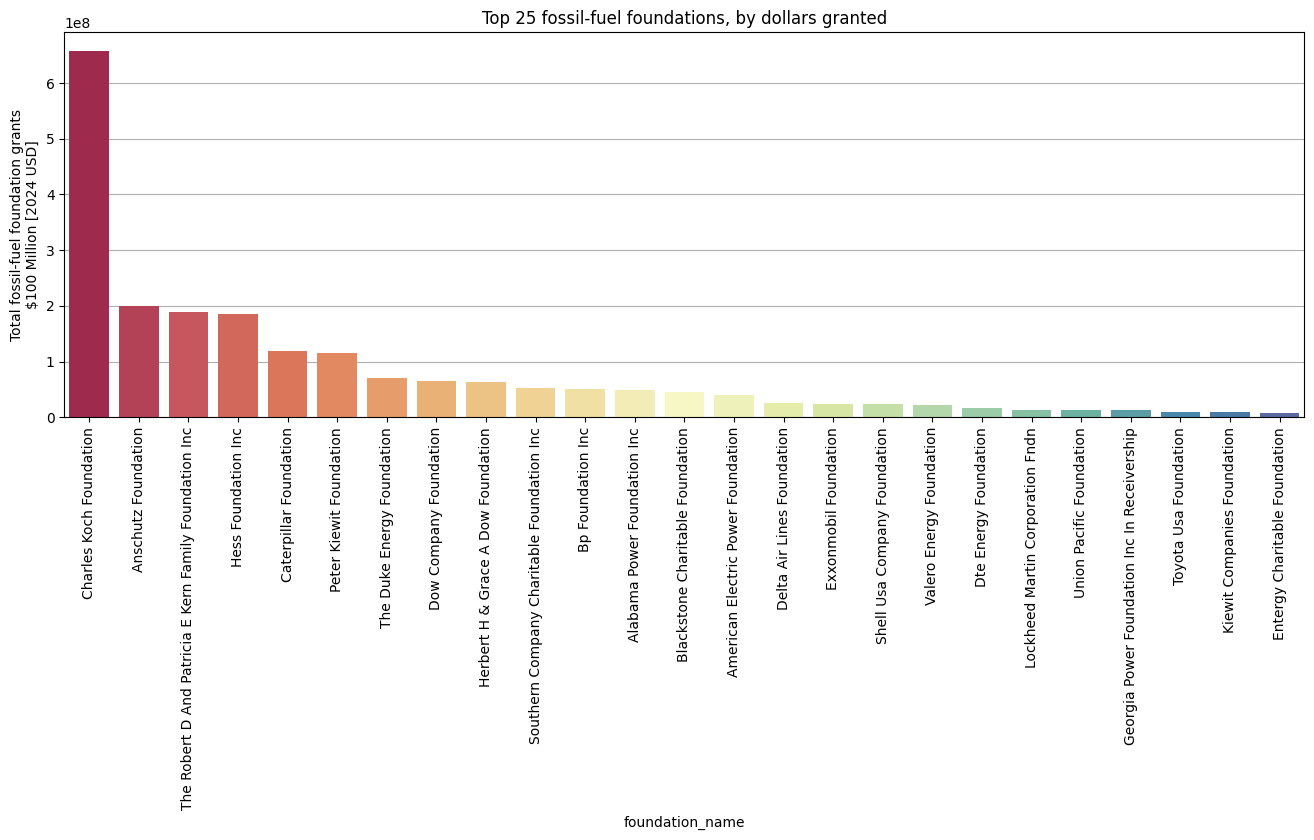

In [19]:
n_orgs = 25

data_df = (
    ff_df[
        [
            "grant_amount_2024_usd",
            "foundation_name",
        ]
    ]
    .groupby(["foundation_name"])
    .sum()
    .sort_values(by="grant_amount_2024_usd", ascending=False)
    .head(n_orgs)
    .reset_index()
)


fig, ax = plt.subplots(1, 1, figsize=(16, 5))
ax.grid(axis="y")
sns.barplot(
    ax=ax,
    data=data_df,
    x="foundation_name",
    y="grant_amount_2024_usd",
    palette="Spectral",
)
ax.set_axisbelow(True)  # put gridlines below bars
ax.set_ylabel("Total fossil-fuel foundation grants\n$100 Million [2024 USD]")
ax.set_title(f"Top {n_orgs:.0f} fossil-fuel foundations, by dollars granted")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Text(0.5, 1.0, 'Family and corporate fossil-fuel foundations have similar giving patterns when it comes to research institutions')

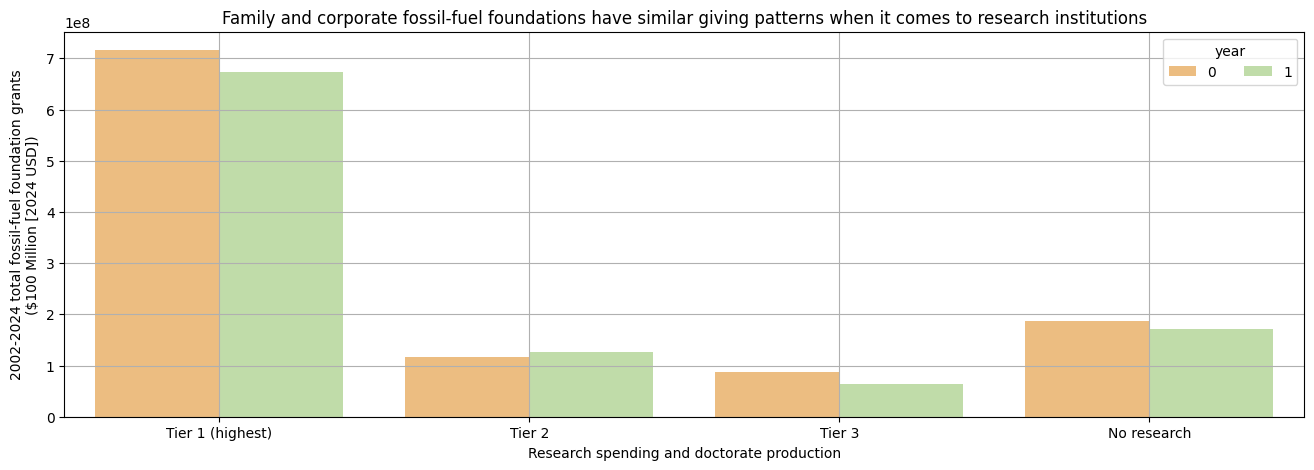

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
col = "research2025"
ff_df["year"] = ff_df["year"].astype(int)
sns.barplot(
    ax=ax,
    data=ff_df[["family", "grant_amount_2024_usd", col]]
    .groupby(["family", col])
    .sum()
    .reset_index(),
    palette="Spectral",
    # sns.color_palette("Spectral", as_cmap=True),
    y="grant_amount_2024_usd",
    x=col,
    hue="family",
    order=[1, 2, 3, -2],
)
ax.legend(ncol=2, loc="best", title="year")
ax.set_xticklabels(["Tier 1 (highest)", "Tier 2", "Tier 3", "No research"])
ax.set_xlabel("Research spending and doctorate production")
ax.grid("on")
ax.set_ylabel(
    "2002-2024 total fossil-fuel foundation grants\n($100 Million [2024 USD])"
)
ax.set_title(
    "Family and corporate fossil-fuel foundations have similar giving patterns when it comes to research institutions"
)

Text(0.5, 1.0, 'Inidvidual family foundation grants are larger than corporate grants, regardless of institution type')

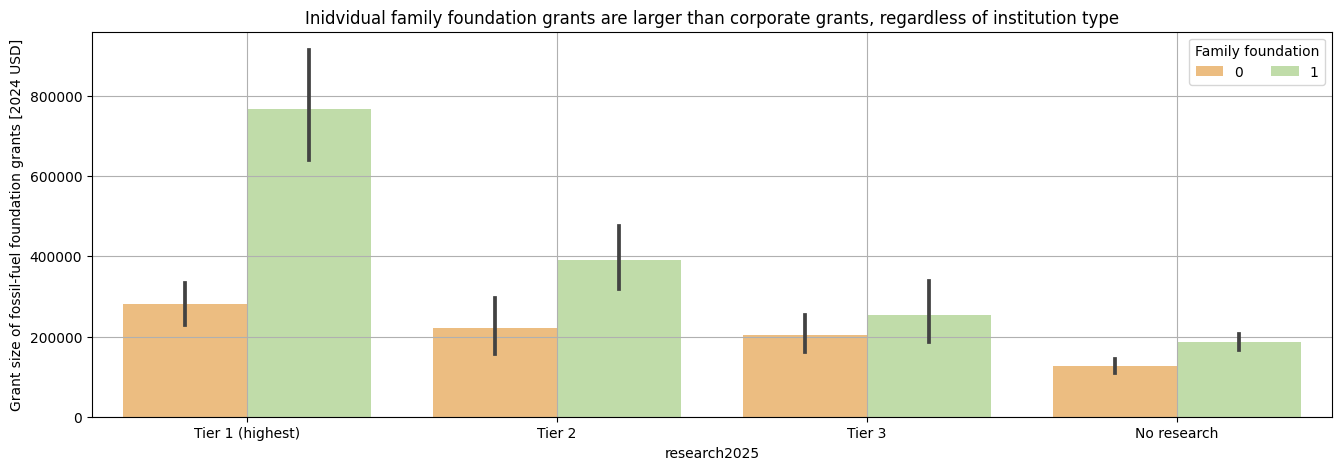

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
col = "research2025"
ff_df["year"] = ff_df["year"].astype(int)
sns.barplot(
    ax=ax,
    data=ff_df[["family", "grant_amount_2024_usd", col]],
    palette="Spectral",
    # sns.color_palette("Spectral", as_cmap=True),
    y="grant_amount_2024_usd",
    x=col,
    hue="family",
    order=[1, 2, 3, -2],
)
ax.legend(ncol=2, loc="best", title="Family foundation")
ax.set_xticklabels(["Tier 1 (highest)", "Tier 2", "Tier 3", "No research"])
# ax.set_xlabel("Research spending and doctorate production")
ax.grid("on")
ax.set_ylabel("Grant size of fossil-fuel foundation grants [2024 USD]")
ax.set_title(
    "Inidvidual family foundation grants are larger than corporate grants, regardless of institution type"
)

<Axes: >

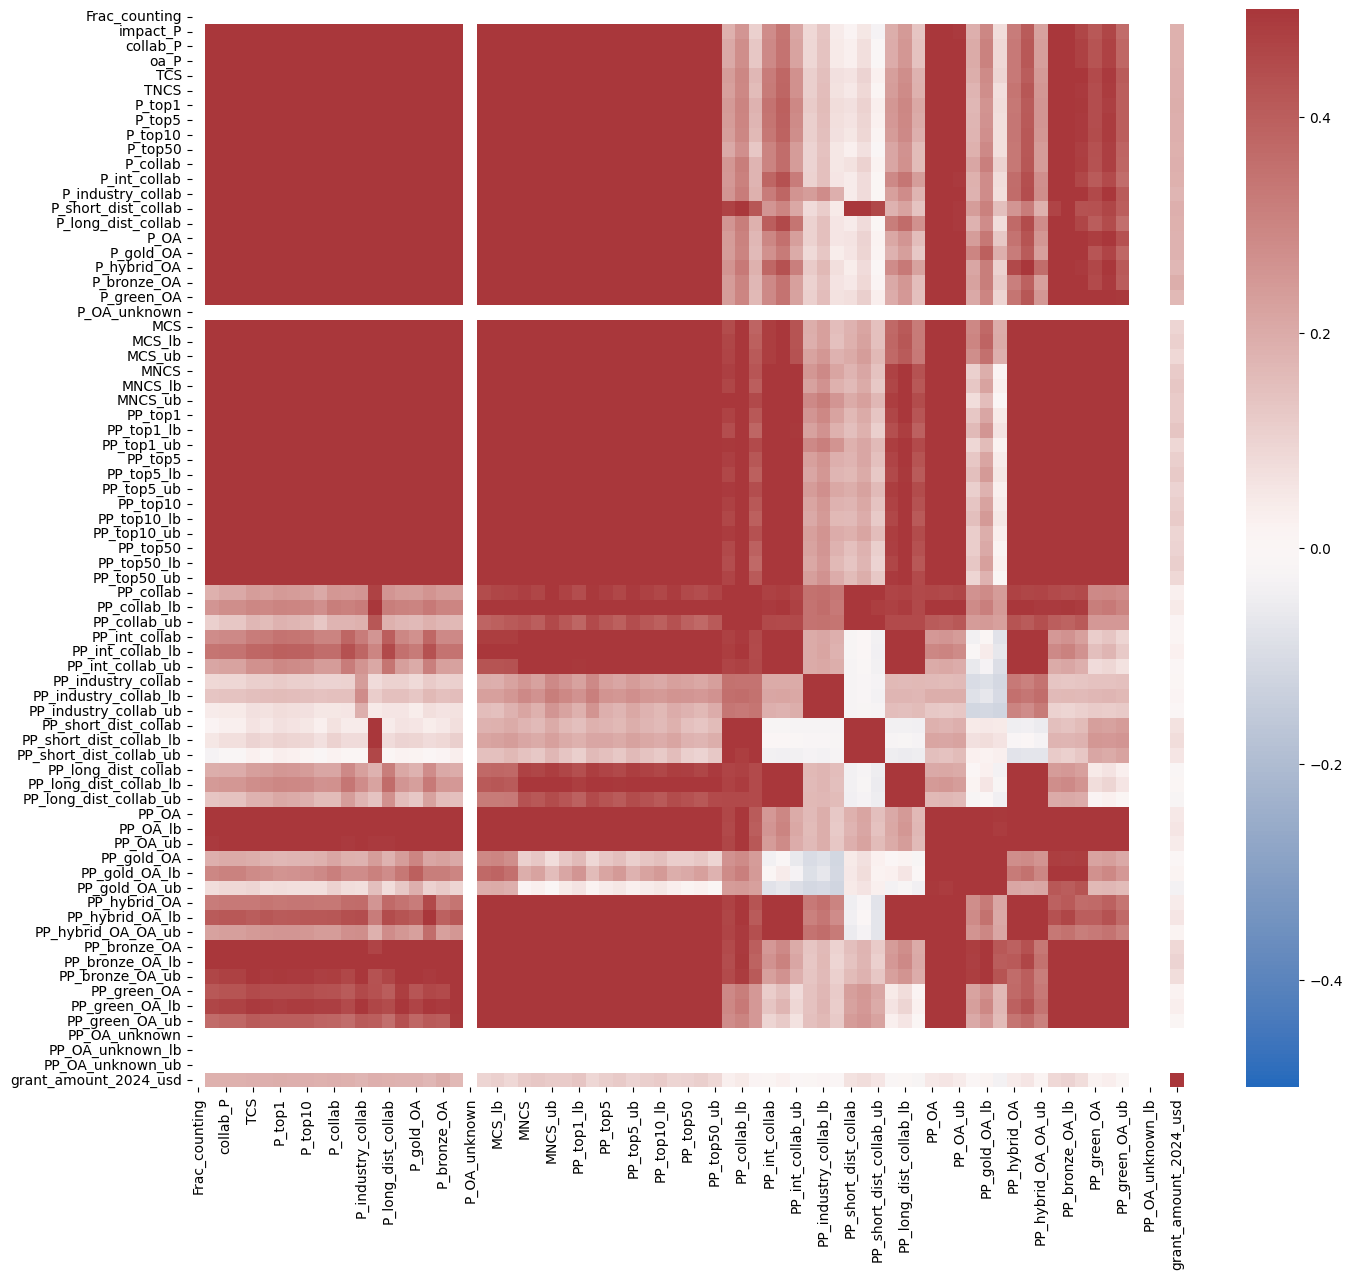

In [23]:
# look for correlations with school ratings
school_df = (
    ff_df[["grant_amount_2024_usd", "instnm"]].groupby("instnm").sum().reset_index()
)
leiden_df = pd.read_csv(
    "/Users/lindseygulden/dev/leg-up-private/projects/foundation/data/mean_cwts.csv"
)
leiden_df = leiden_df.merge(school_df, left_on="carnegie_name", right_on="instnm")
numeric_cols = leiden_df.select_dtypes(include=["number"]).columns.tolist()
fig, ax = plt.subplots(1, 1, figsize=(16, 14))
sns.heatmap(
    ax=ax, data=leiden_df[numeric_cols].corr(), cmap="vlag", vmin=-0.5, vmax=0.5
)

### subsidiaries give locally

In [34]:
print(ff_df[["same_state", "not_same_state", "subsidiary"]].groupby("subsidiary").sum())
odds_ratio(
    [499, 397],
    [2097, 4521],
)

            same_state  not_same_state
subsidiary                            
0.0               2097            4521
1.0                499             397


(2.70985538895075, 2.352022699785406, 3.122128128140691)

### Tier 1 research institutions are less likely to receive funding from organizations in the same state (or neighboring states) than non-tier 1 institutiosn

In [27]:
print(
    ff_df[["same_or_neighbor", "not_same_or_neighbor", "tier1_research"]]
    .loc[ff_df.research2025.isin([1, -2])]
    .groupby("tier1_research")
    .sum()
)

odds_ratio(
    [1298, 1124],
    [1477, 1957],
)

                same_or_neighbor  not_same_or_neighbor
tier1_research                                        
0                           1298                  1124
1                           1477                  1957


(1.5300961119129137, 1.378135419138862, 1.6988128156186024)

In [29]:
print(
    ff_df[["same_state", "not_same_state", "tier1_research"]]
    .loc[ff_df.research2025.isin([1, -2])]
    .groupby("tier1_research")
    .sum()
)

odds_ratio(
    [927, 1495],
    [1078, 2356],
)

                same_state  not_same_state
tier1_research                            
0                      927            1495
1                     1078            2356


(1.3551740185280559, 1.2150780657722955, 1.5114227408312373)